In [1]:
!pip install transformers datasets torch torchvision scikit-learn matplotlib prettytable


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("./train", transform=transform)
test_dataset = datasets.ImageFolder("./test", transform=transform)
train_augmented_dataset = datasets.ImageFolder("./augmented", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=32, shuffle=True)

In [3]:
# Initialize model with empty weights
model = models.resnet50(weights=None).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training function
def train_model(model, train_loader, epochs=15):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

In [4]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return acc, precision, recall, f1


In [5]:
# Print the number of trainable parameters in a model

from prettytable import PrettyTable

table = PrettyTable(["Module", "Parameters"])

total = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        count = param.numel()
        table.add_row([name, count])
        total += count

print(table)
print(f'Total Trainable Parameters: {total}')

+------------------------------+------------+
|            Module            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

In [6]:
print("Training on original dataset...")
train_model(model, train_loader)
results_no_aug = evaluate_model(model, test_loader)

Training on original dataset...
Epoch 1, Loss: 3.5586
Epoch 2, Loss: 0.7073
Epoch 3, Loss: 0.8346
Epoch 4, Loss: 0.6136
Epoch 5, Loss: 0.5653
Epoch 6, Loss: 0.6039
Epoch 7, Loss: 0.6240
Epoch 8, Loss: 0.3677
Epoch 9, Loss: 0.2780
Epoch 10, Loss: 0.2499
Epoch 11, Loss: 0.1468
Epoch 12, Loss: 0.2059
Epoch 13, Loss: 0.1616
Epoch 14, Loss: 0.3493
Epoch 15, Loss: 0.2494
Accuracy: 0.4286, Precision: 0.3939, Recall: 0.4286, F1 Score: 0.3778


In [7]:
print("Training on augmented dataset...")
train_model(model, train_augmented_loader)
results_aug = evaluate_model(model, test_loader)

Training on augmented dataset...
Epoch 1, Loss: 0.8651
Epoch 2, Loss: 0.5026
Epoch 3, Loss: 0.4320
Epoch 4, Loss: 0.1867
Epoch 5, Loss: 0.1115
Epoch 6, Loss: 0.1070
Epoch 7, Loss: 0.2437
Epoch 8, Loss: 0.4652
Epoch 9, Loss: 0.3446
Epoch 10, Loss: 0.2341
Epoch 11, Loss: 0.0579
Epoch 12, Loss: 0.0499
Epoch 13, Loss: 0.0505
Epoch 14, Loss: 0.0494
Epoch 15, Loss: 0.0595
Accuracy: 0.6429, Precision: 0.6458, Recall: 0.6429, F1 Score: 0.6410


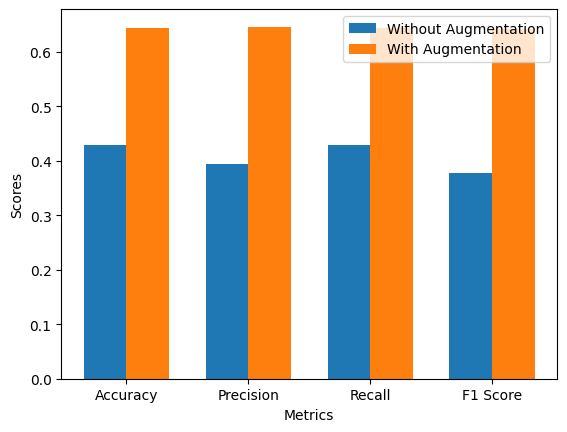

In [11]:
# Plot the results

import matplotlib.pyplot as plt

labels = ["Accuracy", "Precision", "Recall", "F1 Score"]

x = range(len(labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x, results_no_aug, width=0.35, label="Without Augmentation")
rects2 = ax.bar([i + 0.35 for i in x], results_aug, width=0.35, label="With Augmentation")

ax.set_ylabel("Scores")
ax.set_xlabel("Metrics")
ax.set_xticks([i + 0.35 / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

As we can see, the model trained with augmented data performs better than the model trained with the original data. This is because the augmented data provides more examples for the model to learn from, which helps it generalize better to unseen data. Overfitting is reduced due to the increased diversity of the training data, which causes the model's performance on the test set to improve.

In our case, due to the few number of epochs, the model trained on augmented data still does not perform well. But it does beat the model trained on the original data by a fair margin. In practice, data augmentation is a common technique used to drastically improve model performance, especially when working with limited amounts of data.

Architecture of the ResNet model:
<img src="./ResNet50Architecture.jpg"/>